c:\Users\Andri\Documents\GitHub\Cluster_detection_python\lib\OIP21_group3.py:302: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=5,
c:\Users\Andri\Documents\GitHub\Cluster_detection_python\lib\OIP21_group3.py:126: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=3,labels=thresh)


------------------------ Text Printout ------------------


Total number of Clusters :  365


Picture with most ammout of lines :  ./pictures/R001_001.tif 
Number of Clusters in picture :  365 
Number of Lines in picture :  994 
Average number of lines in clusters :  2.723287671232877
Mean number of a cluster particles :  10.22  Median number of a cluster particles :  10.0 
Standard Deviation of cluster particles :  4.54  Variance of cluster particles :  20.61


------------------------ Time Data ------------------
Tottal run time :  70.87951421737671 
Average run time :  70.87951421737671 
Shortest run time :  70.87951421737671 
Longest run time :  70.87951421737671 
Longest run time picture :  ./pictures/R001_001.tif


-----------------------------------------------------


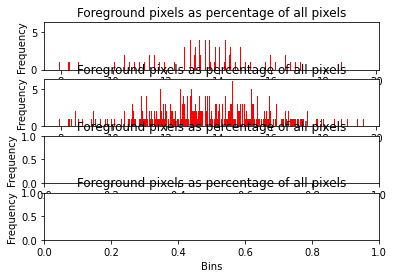

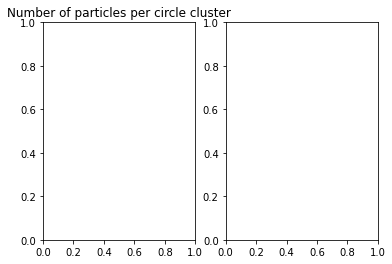

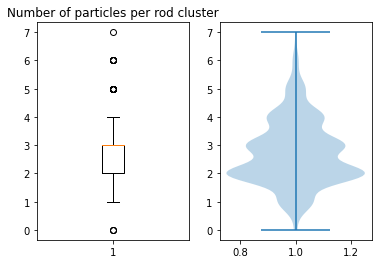

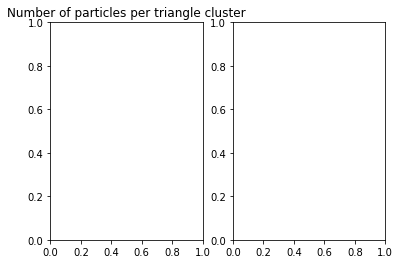

In [1]:
from lib.OIP21_group3 import *

if __name__ == '__main__':
    img_array = ['./pictures/001_002.tif', './pictures/R001_001.tif', './pictures/T001.png']
    img_array = ['./pictures/T001.png']]

    totalNumberOfClusters = 0  
    totalNumberOfParticles = 0 
    totalNumberOfCircles = 0  
    lineClusterCount = 0

    totalTime = 0
    shortestTime = 900000000
    longestTime = 0
    circleClusters = 0

    shortestPicture = 'asd'
    longestPicture = 'asd'
    circlePicture = 'asd'
    linePicture = 'asd'
    trianglePicture = 'asd'

    count_clusters = 0
    count_foreground_pixels = [[], [], []]
    count_circles = []
    count_rods = []
    count_triangles = []
    
    totalNumberOfLines = 0


    printOutThings = True
    writeToFile = False 

    for x in img_array:  
        t = time.time()
        clusterArray = [] 
        circleArray = []  
        watershed_clusters=[]
        watershed_clustersC=[]
        ForegBackg=[]
        ForegBackgRod=[] 
        numberOfClusters = 0
        numberOfCircles = 0
        numberOfClassifyingCircles = 0
        numberOfTriangles = 0
        trianglesClusters = 0
        circleType = False
        rodType = False
        triangleType = False 

        # Read the image
        img_orginal = cv2.imread(x, cv2.IMREAD_GRAYSCALE)

        # The Triangle and Circle image have some stuff at the bottom we need to cut of,
        img_orginal = img_orginal[0:870, :]  ## cut off the bottom manual at this moment

        pre_filterd_image = pre_region_labeling_filtering(img_orginal)

        labelsOIP, zones = FloodFillLabeling_modified(pre_filterd_image)

        clusterArray = segmenting(img_orginal, zones)

        size = math.ceil(math.sqrt(len(clusterArray)))
        count = 1
        count_b = 1

        for numbers in range(10):
            img_edge_classify, img_thresh_classify = pre_conditioning(clusterArray[numbers])
            img_threshClassify,watershed_imgClassify, cC = locwatershed(cv2.cvtColor(clusterArray[numbers], cv2.COLOR_GRAY2BGR),img_thresh_classify)
            watershed_clustersC.append(cC)
            circlesClassify = openCv_HoughCircles(img_edge_classify, 12, 6, 12)

            if circlesClassify is not None:
                 for things in circlesClassify[0, :]:
                    numberOfClassifyingCircles  = numberOfClassifyingCircles + 1

            if (numberOfClassifyingCircles/np.sum(watershed_clustersC)) >= 0.9: 
                circleType = True
            elif (numberOfClassifyingCircles/np.sum(watershed_clustersC)) >= 0.40: 
                triangleType = True
            else: 
                rodType = True


        for i in clusterArray:
            numberOfClusters = numberOfClusters + 1
            totalNumberOfClusters = totalNumberOfClusters + 1

            img_edge, img_thresh = pre_conditioning(i)
            img_thresh2,watershed_img, c = locwatershed(cv2.cvtColor(i, cv2.COLOR_GRAY2BGR),img_thresh)
            watershed_clusters.append(c)
            m,n= np.shape(img_thresh)
            try:
                ForegBackg.append(cv2.countNonZero(img_thresh)/(c) )
            except ZeroDivisionError:
                ForegBackg.append(cv2.countNonZero(img_thresh))

            # Principal component analasys 
            if circleType == True: 
                circles = openCv_HoughCircles(img_edge, 12, 6, 12)
                numberOfCircles = 0
                for j in circles[0, :]:
                    numberOfCircles = numberOfCircles + 1
                totalNumberOfCircles = totalNumberOfCircles + numberOfCircles
                circlePicture = x
                circleClusters = numberOfClusters
                count_circles.append(numberOfCircles)
            elif triangleType == True:
                numberOfTriangles = numberOfTriangles + c
                trianglePicture = x
                trianglesClusters = numberOfClusters
                count_triangles.append(c)
            elif rodType == True: 
                linePicture = x
                lineClusterCount = numberOfClusters
                img_lines, numberOfLines = countRods(i)
                totalNumberOfLines = totalNumberOfLines + numberOfLines
                count_rods.append(numberOfLines)
                try:
                    ForegBackgRod.append(cv2.countNonZero(img_thresh)/(numberOfLines) )
                except ZeroDivisionError:
                    pass
            else: 
                print("-------------------------\n\n[ERROR] - Unable to classify cluster type!! \n\n-------------------------")

            count_foreground_pixels[img_array.index(x)].append((np.count_nonzero(img_thresh)/img_thresh.size)*100)

            if printOutThings == True:
                # Basic plotting 
                plt.subplot(2*size, size, count)
                plt.imshow(watershed_img, 'gray', vmin=0, vmax=255)
                plt.xticks([])
                plt.yticks([])
                count += 1
                plt.subplot(2 * size,  size, count)
                plt.imshow(i, 'gray', vmin=0, vmax=255)
                plt.xticks([])
                plt.yticks([])
                count += 1

        if printOutThings == True:
            x = watershed_clusters
            y=ForegBackg ##normalize the data?
            plt.show()

            if rodType == True:
                n, bins, patches = plt.hist(count_rods,20, facecolor='blue', alpha=0.5)
                print("n", n,"bins", bins, "patches", patches)
                plt.xlabel('Bins')
                plt.ylabel('Frequency')
                plt.title('Rods Nr particles')
                plt.show()

                n, bins, patches = plt.hist(ForegBackgRod,bins=40,  facecolor='red', alpha=0.5)
                print("n", n, "bins", bins, "patches", patches)
                plt.xlabel('Bins')
                plt.ylabel('Frequency')
                plt.title('Area per perticle lines')
                plt.show()

            if rodType == False:
                n, bins, patches = plt.hist(x,20, facecolor='blue', alpha=0.5)
                print("n", n,"bins", bins, "patches", patches)
                plt.xlabel('Bins')
                plt.ylabel('Frequency')
                plt.title('Nr particles watershed')
                plt.show()

                n, bins, patches = plt.hist(y,10,  facecolor='red', alpha=0.5)
                print("n", n, "bins", bins, "patches", patches)
                plt.xlabel('Bins')
                plt.ylabel('Frequency')
                plt.title('Area per perticle watershed')
                plt.show()

            x = np.linspace(0,450, len(n))
            xdata = np.linspace(0, 450, 40)
            fittingFunction, cov = scipy.stats.distributions.norm.fit(y)
            fitted_data = scipy.stats.distributions.norm.pdf(xdata, fittingFunction, cov)
            plt.plot(xdata, fitted_data, 'r-')
            # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
            plt.show()

            plt.scatter(x, n)
            plt.show()

            if (writeToFile):
                name = x.replace(".", "")
                name = name.replace("png", "")
                name = name.replace("tif", "")
                print("Data Storred in ", "." + name + ".txt", "a")
                f = open("." + name + ".txt", "a")
                for i in range(len(n)):
                    if (n[i] > 0):
                        f.write(str(n[i]) + "," + str(bins[i]) + "\n")
                f.close()

            xdata = np.linspace(0, 450, 40)
            fittingFunction, cov = scipy.stats.distributions.norm.fit(ForegBackg)
            fitted_data = scipy.stats.distributions.norm.pdf(xdata, fittingFunction, cov)
            plt.plot(xdata, fitted_data, 'r-')


        elapse = time.time() - t
        if elapse <= shortestTime:
            shortestTime = elapse
            shortestPicture = x

        if elapse >= longestTime:
            longestTime = elapse
            longestPicture = x

        totalTime = totalTime + elapse

    print("------------------------ Text Printout ------------------\n\n")
    print("Total number of Clusters : ", totalNumberOfClusters)
    
    if circleClusters != 0: 
        print("\n\nPicture with most ammount of Circles : ", circlePicture,
        "\nNumber of Clusters in picture : ", circleClusters, 
        "\nNumber of Circles in picture : ", totalNumberOfCircles, 
        "\nAverage number of circles in clusters : ", totalNumberOfCircles / circleClusters)

    if lineClusterCount != 0:   
        print("\n\nPicture with most ammout of lines : ", linePicture,
        "\nNumber of Clusters in picture : ", lineClusterCount, 
        "\nNumber of Lines in picture : ", totalNumberOfLines, 
        "\nAverage number of lines in clusters : ", totalNumberOfLines / lineClusterCount)

    if trianglesClusters != 0: 
        print("\n\nPicture with most ammount of Triangles : ", trianglePicture, 
        "\nNumber of Clusters in picture : ", trianglesClusters, 
        "\nNumber of Triangles in clusters : ", numberOfTriangles, 
        "\nAverage number of Triangles in clusters : ", numberOfTriangles / trianglesClusters)

    print("Mean number of a cluster particles : ", round(np.mean(watershed_clusters),2),
    " Median number of a cluster particles : ", round(np.median(watershed_clusters),2),
    "\nStandard Deviation of cluster particles : ",round(np.std(watershed_clusters),2),
    " Variance of cluster particles : ",round(np.var(watershed_clusters),2))

    print("\n\n------------------------ Time Data ------------------")
    print("Tottal run time : ", totalTime, 
    "\nAverage run time : ", totalTime / len(img_array), 
    "\nShortest run time : ", shortestTime, 
    "\nLongest run time : ", longestTime, 
    "\nLongest run time picture : ", longestPicture)
    print("\n\n-----------------------------------------------------")

    fig, axs1 = plt.subplots(4, 1)
    fig, axs2 = plt.subplots(1, 2)
    fig, axs3 = plt.subplots(1, 2)
    fig, axs4 = plt.subplots(1, 2)

    axs1[0].set_xlabel('Bins')
    axs1[0].set_ylabel('Frequency')
    axs1[0].set_title('Foreground pixels as percentage of all pixels')
    axs1[1].set_xlabel('Bins')
    axs1[1].set_ylabel('Frequency')
    axs1[1].set_title('Foreground pixels as percentage of all pixels')
    axs1[2].set_xlabel('Bins')
    axs1[2].set_ylabel('Frequency')
    axs1[2].set_title('Foreground pixels as percentage of all pixels')
    axs1[3].set_xlabel('Bins')
    axs1[3].set_ylabel('Frequency')
    axs1[3].set_title('Foreground pixels as percentage of all pixels')

    axs2[0].set_title('Number of particles per circle cluster')
    axs3[0].set_title('Number of particles per rod cluster')
    axs4[0].set_title('Number of particles per triangle cluster')

    count_circles = np.array(count_circles)
    count_rods = np.array(count_rods)
    count_triangles = np.array(count_triangles)

    axs1[0].hist(count_foreground_pixels, numberOfClusters, color=["red", "green", "blue"])
    axs1[1].hist(count_foreground_pixels[0], len(count_foreground_pixels[0]), color="red")
    #axs1[2].hist(count_foreground_pixels[1], len(count_foreground_pixels[1]), color="green")
    #axs1[3].hist(count_foreground_pixels[2], len(count_foreground_pixels[2]), color="blue")
    
    if len(count_circles) != 0: 
        axs2[0].boxplot(count_circles)
        axs2[1].violinplot(count_circles)

    if len(count_rods) != 0:
        axs3[0].boxplot(count_rods)
        axs3[1].violinplot(count_rods)

    if len(count_triangles) != 0: 
        axs4[0].boxplot(count_triangles)
        axs4[1].violinplot(count_triangles)
    #plt.show()


    #-----------------   First idea of rod counting  --------------------
    # N, M = img_edge.shape
    # if numberOfCircles < 3: 

    #     Nth = (np.floor_divide(M,2)).astype(np.uint8) # number of THETA values in the accumulator array
    #     Nr = (np.floor_divide(N,2)).astype(np.uint8)  # number of R values in the accumulator array
    #     K = 30

    #     Acc, MaxIDX, MaxTH, MaxR = hough_lines(img_edge, Nth, Nr, K)
    #     #MaxTH, MaxR = filter_lines(MaxTH, MaxR, 1, 10)

    #     if K > len(MaxTH): K = len(MaxTH)

    #     avg_angles = []
    #     for line in range(K):
    #         #oip.plot_line_rth(E, MaxTH[i], MaxR[i], ax)
    #         #plot_line_rth(M, N, MaxR[line], MaxTH[line], output_axs[count-1])

    #         avg_angles.append(np.average(np.abs(MaxTH - MaxTH[line])))

    #     avg_angle = np.average(avg_angles)
    #     #avg_angle = np.sum(avg_angles)/K
    #     print("AVERAGE ANGLE")
    #     print(avg_angle)
    # --------------------------------